The following codes are written by both Yining Feng and Yunze Chen based on Dr. Jason Brownlee's book **Deep Learning for Time Series Forecasting**. The Monte Carlo Simulation function *monte_carlo_sim(avg, std_dev, num_simulations, df_input)* is created based on the tutorial by Chris Moffitt (https://pbpython.com/monte-carlo.html)

In [1]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import hstack
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load all data
data = pd.read_csv("data.csv")
data.head()

,Date,Order
0,2017-02-04,6386
1,2017-02-05,328
2,2017-02-06,7653
3,2017-02-07,7811
4,2017-02-08,8530


In [3]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))


Number of unique values:
Date     1092
Order    1058
dtype: int64


## Train and Test Sets
We will use the first two years of data for training predictive models and the final year for evaluating models.

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday.

We will split the data into standard weeks, working backwards from the test dataset.

In [5]:
# split into standard weeks
from numpy import split
# split a univariate dataset into train/test sets
def split_dataset(data):
# split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    train.reset_index(inplace=True)
    test.reset_index(inplace=True)
    train.drop(columns={'index'}, inplace=True)
    test.drop(columns={'index'}, inplace=True)
    return train, test
# validate train data
train, test = split_dataset(data)

# get random series for Monte Carlo
def monte_carlo_sim(avg, std_dev, num_simulations, df_input):

    # get the parameter of normal distribution
    num_reps = len(df_input['Date'])
    df_final = df_input

    for i in range(1, num_simulations):
        # get random number based on normal distribution
        pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

        # assemble the dataframe of a new series
        df_temp = pd.DataFrame(index=range(num_reps),
                               data={
                                   'Date': df_input['Date'],
                                   'Target': df_input['Order'],
                                   'Pct_To_Target': pct_to_target})
        df_temp['Order'] = df_temp['Target'] * df_temp['Pct_To_Target']
        df_temp = df_temp.round({'Order': 0})
        # df_temp['Series'] = i
        df_temp.drop(columns=['Target', 'Pct_To_Target'], inplace=True)

        # append the new series
        df_final = df_final.append(df_temp, ignore_index=True)

    return df_final

# validate simulation data
test_1 = monte_carlo_sim(1, 0.1, 10, test)

c:\users\cyxlq\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
# restructure into windows of weekly data
def split_weekly(data):
    data_return = array(split(data, len(data)/7))

    return data_return

# validate split weekly window
weekly_train = split_weekly(train)
weekly_test = split_weekly(test)


The daily data starts in early 2017.

The first Sunday in the dataset is February 5th, which is the second row of data.

Organizing the data into standard weeks gives 109 full standard weeks for training a predictive model.

The final year of the data is in 2019 and the first Sunday for 2019 was March 10th. The data ends in mid January 2020 and the closest final Saturday in the data is January 25th. This gives 46 weeks of test data.


## Walk-Forward Validation
Models will be evaluated using a scheme called walk-forward validation.

This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data.

The walk-forward validation approach to evaluating predictive models on this dataset is provided below named evaluate_model().

The train and test datasets in standard-week format are provided to the function as arguments. An additional argument n_input is provided that is used to define the number of prior observations that the model will use as input in order to make a prediction.

Two new functions are called: one to build a model from the training data called build_model() and another that uses the model to make forecasts for each new standard week called forecast(). 

We are working with neural networks, and as such, they are generally slow to train but fast to evaluate. This means that the preferred usage of the models is to build them once on historical data and to use them to forecast each step of the walk-forward validation. The models are static (i.e. not updated) during their evaluation.

In [9]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
    # predict the week
        yhat_sequence = forecast(model, history, n_input)
    # store the predictions
        predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Once we have the evaluation for a model, we can summarize the performance.

The function below named summarize_scores() will display the performance of a model as a single line for easy comparison with other models.

In [10]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

## LSTMs for Multi-Step Forecasting

We will explore a suite of LSTM architectures for multi-step time series forecasting. Specifically, we will look at how to develop the following models:

* LSTM model with vector output for multi-step forecasting with univariate input data.
* Encoder-Decoder LSTM model for multi-step forecasting with univariate input data.
* CNN-LSTM Encoder-Decoder model for multi-step forecasting with univariate input data.
* ConvLSTM Encoder-Decoder model for multi-step forecasting with univariate input data.

## LSTM Model With Univariate Input and Vector Output

We will start off by developing a vanilla LSTM model that reads in a sequence of days of total number of daily orders and predicts a vector output of the next standard week of daily orders.

The number of prior days used as input defines the one-dimensional (1D) subsequence of data that the LSTM will read and learn to extract features.

In [11]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

One sample will be comprised of seven time steps with one feature for the seven days of total daily orders.

The training dataset has 159 weeks of data, so the shape of the training dataset would be:
* [109, 7, 1]

The data would use the prior standard week to predict the next standard week. A problem is that 109 instances is not a lot to train a neural network.

In [12]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

In [13]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [14]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.5f' % s for s in scores])
    print('%s: [%.6f] %s' % (name, score, s_scores))

A way to create a lot more training data is to change the problem during training to predict the next seven days given the prior seven days, regardless of the standard week.

This only impacts the training data, and the test problem remains the same: predict the daily power consumption for the next standard week given the prior standard week.

This will require a little preparation of the training data.

In [15]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
# flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

We then need to iterate over the time steps and divide the data into overlapping windows; each iteration moves along one time step and predicts the subsequent seven days.

We can do this by keeping track of start and end indexes for the inputs and outputs as we iterate across the length of the flattened data in terms of time steps.

We can also do this in a way where the number of inputs and outputs are parameterized (e.g. n_input, n_out) so that you can experiment with different values or adapt it for your own problem.

Above is a function named to_supervised() that takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [16]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 2, 200, 40960
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200,
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Next, we can define and fit the LSTM model on the training data.

This multi-step time series forecasting problem is an autoregression. That means it is likely best modeled where that the next seven days is some function of observations at prior time steps. This and the relatively small amount of data means that a small model is required.

We will develop a model with a single hidden LSTM layer with 200 units. The number of units in the hidden layer is unrelated to the number of time steps in the input sequences. The LSTM layer is followed by a fully connected layer with 200 nodes that will interpret the features learned by the LSTM layer. Finally, an output layer will directly predict a vector with seven elements, one for each day in the output sequence.

We will use the mean squared error loss function as it is a good match for our chosen error metric of RMSE. We will use the efficient Adam implementation of stochastic gradient descent and fit the model for 70 epochs with a batch size of 16.

The small batch size and the stochastic nature of the algorithm means that the same model will learn a slightly different mapping of inputs to outputs each time it is trained. This means results may vary when the model is evaluated. You can try running the model multiple times and calculate an average of model performance.

The build_model() above prepares the training data, defines the model, and fits the model on the training data, returning the fit model ready for making predictions.

In [17]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

We are using walk-forward validation to evaluate the model as described in the previous section.

This means that we have the observations available for the prior week in order to predict the coming week. These are collected into an array of standard weeks called history.

In order to predict the next standard week, we need to retrieve the last days of observations. As with the training data, we must first flatten the history data to remove the weekly structure so that we end up with eight parallel time series.

Next, we need to retrieve the last seven days of daily total power consumed (feature index 0).

We will parameterize this as we did for the training data so that the number of prior days used as input by the model can be modified in the future.

We then make a prediction using the fit model and the input data and retrieve the vector of seven days of output.

The forecast() function above implements this and takes as arguments the model fit on the training dataset, the history of data observed so far, and the number of input time steps expected by the model.

In [18]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [19]:
# set GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# load the new file
dataset = pd.read_csv('data.csv',
                      infer_datetime_format=True,
                      parse_dates=['Date'])

# split into train and test
train_ori, test_ori = split_dataset(dataset)

train = train_ori
test = test_ori

c:\users\cyxlq\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
# Set parameters for Monte Carlo
avg = 1
std_dev = 0.1
num_sim = 100

# add monte carlo simulated data
train = monte_carlo_sim(avg, std_dev, num_sim, train)
test = monte_carlo_sim(avg, std_dev, num_sim, test)

# strip date and series
train.drop(columns={'Date'}, inplace=True)
test.drop(columns={'Date'}, inplace=True)

In [21]:
# add MinMax Scaler
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [22]:
# break into 7 days window
train = split_weekly(train)
test = split_weekly(test)


Epoch 1/200
2/2 - 0s - loss: 0.0282
Epoch 2/200
2/2 - 0s - loss: 0.0220
Epoch 3/200
2/2 - 0s - loss: 0.0163
Epoch 4/200
2/2 - 0s - loss: 0.0118
Epoch 5/200
2/2 - 0s - loss: 0.0108
Epoch 6/200
2/2 - 0s - loss: 0.0118
Epoch 7/200
2/2 - 0s - loss: 0.0108
Epoch 8/200
2/2 - 0s - loss: 0.0100
Epoch 9/200
2/2 - 0s - loss: 0.0101
Epoch 10/200
2/2 - 0s - loss: 0.0103
Epoch 11/200
2/2 - 0s - loss: 0.0102
Epoch 12/200
2/2 - 0s - loss: 0.0100
Epoch 13/200
2/2 - 0s - loss: 0.0099
Epoch 14/200
2/2 - 0s - loss: 0.0098
Epoch 15/200
2/2 - 0s - loss: 0.0097
Epoch 16/200
2/2 - 0s - loss: 0.0097
Epoch 17/200
2/2 - 0s - loss: 0.0097
Epoch 18/200
2/2 - 0s - loss: 0.0097
Epoch 19/200
2/2 - 0s - loss: 0.0097
Epoch 20/200
2/2 - 0s - loss: 0.0096
Epoch 21/200
2/2 - 0s - loss: 0.0096
Epoch 22/200
2/2 - 0s - loss: 0.0096
Epoch 23/200
2/2 - 0s - loss: 0.0096
Epoch 24/200
2/2 - 0s - loss: 0.0096
Epoch 25/200
2/2 - 0s - loss: 0.0096
Epoch 26/200
2/2 - 0s - loss: 0.0095
Epoch 27/200
2/2 - 0s - loss: 0.0095
Epoch 28/2

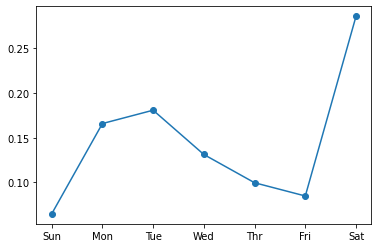

In [23]:
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('LSTM', score, scores)
# plot scores
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

A plot of the daily RMSE is created and shown as above.

The plot shows that perhaps Fridays are easier days to forecast than the other days and that perhaps Saturday at the end of a standard week is the hardest day to forecast.

## Encoder-Decoder LSTM Model With Univariate Input

The model will be comprised of two sub models, the encoder to read and encode the input sequence, and the decoder that will read the encoded input sequence and make a one-step prediction for each element in the output sequence.

As before, we define an LSTM hidden layer with 200 units. This is the decoder model that will read the input sequence and will output a 200 element vector (one output per unit) that captures features from the input sequence. We will use 14 days of total power consumption as input.

First, the internal representation of the input sequence is repeated multiple times, once for each time step in the output sequence. This sequence of vectors will be presented to the LSTM decoder.

We then define the decoder as an LSTM hidden layer with 200 units. Importantly, the decoder will output the entire sequence, not just the output at the end of the sequence as we did with the encoder. This means that each of the 200 units will output a value for each of the seven days, representing the basis for what to predict for each day in the output sequence.

We will then use a fully connected layer to interpret each time step in the output sequence before the final output layer. Importantly, the output layer predicts a single step in the output sequence, not all seven days at a time. 

It means that the same fully connected layer and output layer will be used to process each time step provided by the decoder. To achieve this, we will wrap the interpretation layer and the output layer in a TimeDistributed wrapper that allows the wrapped layers to be used for each time step from the decoder.

In [24]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [25]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 2, 200, 128
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200,
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200,
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


Epoch 1/200
596/596 - 3s - loss: 0.0090
Epoch 2/200
596/596 - 3s - loss: 0.0079
Epoch 3/200
596/596 - 2s - loss: 0.0073
Epoch 4/200
596/596 - 2s - loss: 0.0067
Epoch 5/200
596/596 - 3s - loss: 0.0059
Epoch 6/200
596/596 - 2s - loss: 0.0049
Epoch 7/200
596/596 - 3s - loss: 0.0040
Epoch 8/200
596/596 - 2s - loss: 0.0035
Epoch 9/200
596/596 - 2s - loss: 0.0030
Epoch 10/200
596/596 - 3s - loss: 0.0027
Epoch 11/200
596/596 - 2s - loss: 0.0024
Epoch 12/200
596/596 - 3s - loss: 0.0022
Epoch 13/200
596/596 - 2s - loss: 0.0020
Epoch 14/200
596/596 - 3s - loss: 0.0019
Epoch 15/200
596/596 - 3s - loss: 0.0018
Epoch 16/200
596/596 - 2s - loss: 0.0017
Epoch 17/200
596/596 - 2s - loss: 0.0016
Epoch 18/200
596/596 - 2s - loss: 0.0015
Epoch 19/200
596/596 - 2s - loss: 0.0015
Epoch 20/200
596/596 - 2s - loss: 0.0014
Epoch 21/200
596/596 - 2s - loss: 0.0014
Epoch 22/200
596/596 - 2s - loss: 0.0013
Epoch 23/200
596/596 - 2s - loss: 0.0013
Epoch 24/200
596/596 - 2s - loss: 0.0013
Epoch 25/200
596/596 - 2s

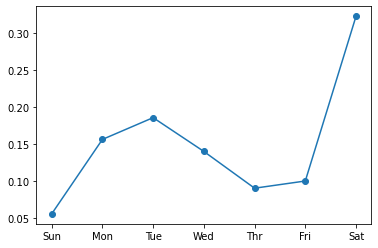

In [26]:
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('LSTM-LSTM', score, scores)
# plot scores
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

A plot of the daily RMSE is created and shown as above.

The plot shows that perhaps Thursdays are easier days to forecast than the other days and that perhaps Saturday at the end of a standard week is the hardest day to forecast.

## CNN-LSTM Encoder-Decoder Model With Univariate Input

We will define a simple but effective CNN architecture for the encoder that is comprised of two convolutional layers followed by a max pooling layer, the results of which are then flattened.

The first convolutional layer reads across the input sequence and projects the results onto feature maps. The second performs the same operation on the feature maps created by the first layer, attempting to amplify any salient features. We will use 64 feature maps per convolutional layer and read the input sequences with a kernel size of three time steps.

The max pooling layer simplifies the feature maps by keeping 1/4 of the values with the largest (max) signal. The distilled feature maps after the pooling layer are then flattened into one long vector that can then be used as input to the decoding process.

In [27]:
# univariate multi-step encoder-decoder cnn-lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [28]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 2, 200, 128
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200,
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


Epoch 1/200
596/596 - 2s - loss: 0.0084
Epoch 2/200
596/596 - 2s - loss: 0.0057
Epoch 3/200
596/596 - 2s - loss: 0.0047
Epoch 4/200
596/596 - 2s - loss: 0.0041
Epoch 5/200
596/596 - 2s - loss: 0.0038
Epoch 6/200
596/596 - 2s - loss: 0.0034
Epoch 7/200
596/596 - 2s - loss: 0.0032
Epoch 8/200
596/596 - 2s - loss: 0.0030
Epoch 9/200
596/596 - 2s - loss: 0.0029
Epoch 10/200
596/596 - 2s - loss: 0.0027
Epoch 11/200
596/596 - 2s - loss: 0.0026
Epoch 12/200
596/596 - 2s - loss: 0.0025
Epoch 13/200
596/596 - 2s - loss: 0.0024
Epoch 14/200
596/596 - 2s - loss: 0.0023
Epoch 15/200
596/596 - 2s - loss: 0.0022
Epoch 16/200
596/596 - 2s - loss: 0.0022
Epoch 17/200
596/596 - 2s - loss: 0.0021
Epoch 18/200
596/596 - 2s - loss: 0.0021
Epoch 19/200
596/596 - 2s - loss: 0.0020
Epoch 20/200
596/596 - 2s - loss: 0.0019
Epoch 21/200
596/596 - 2s - loss: 0.0019
Epoch 22/200
596/596 - 2s - loss: 0.0018
Epoch 23/200
596/596 - 2s - loss: 0.0018
Epoch 24/200
596/596 - 2s - loss: 0.0018
Epoch 25/200
596/596 - 2s

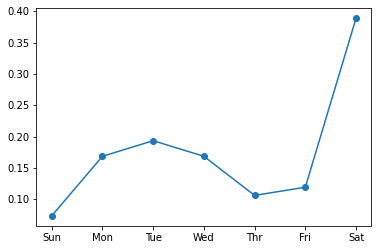

In [29]:
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('Con1D-LSTM', score, scores)
# plot scores
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

A plot of the daily RMSE is created and shown as above.

The plot shows that perhaps Thursdays are easier days to forecast than the other days and that perhaps Saturday at the end of a standard week is the hardest day to forecast.

## ConvLSTM Encoder-Decoder Model With Univariate Input

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units for each time step themselves.

Where each time step of data is defined as an image of (rows * columns) data points.

We are working with a one-dimensional sequence of total daily orders, which we can split into a sequence with a length of seven days for each time step. The ConvLSTM can then perform the CNN process on the seven days of data within each.

In [30]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [31]:
# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 2, 200, 128
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64,
                         kernel_size=(1,3),
                         activation='relu',
                         input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200,
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   recurrent_dropout=0,
                   unroll=False,
                   use_bias=True,
                   return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [32]:
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [33]:
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Epoch 1/200
596/596 - 8s - loss: 0.0083
Epoch 2/200
596/596 - 8s - loss: 0.0050
Epoch 3/200
596/596 - 8s - loss: 0.0038
Epoch 4/200
596/596 - 8s - loss: 0.0030
Epoch 5/200
596/596 - 8s - loss: 0.0025
Epoch 6/200
596/596 - 8s - loss: 0.0022
Epoch 7/200
596/596 - 8s - loss: 0.0019
Epoch 8/200
596/596 - 8s - loss: 0.0017
Epoch 9/200
596/596 - 8s - loss: 0.0016
Epoch 10/200
596/596 - 8s - loss: 0.0014
Epoch 11/200
596/596 - 8s - loss: 0.0013
Epoch 12/200
596/596 - 8s - loss: 0.0012
Epoch 13/200
596/596 - 8s - loss: 0.0011
Epoch 14/200
596/596 - 8s - loss: 0.0011
Epoch 15/200
596/596 - 8s - loss: 9.9522e-04
Epoch 16/200
596/596 - 8s - loss: 9.4637e-04
Epoch 17/200
596/596 - 8s - loss: 9.0214e-04
Epoch 18/200
596/596 - 8s - loss: 8.6176e-04
Epoch 19/200
596/596 - 8s - loss: 8.2802e-04
Epoch 20/200
596/596 - 8s - loss: 7.9467e-04
Epoch 21/200
596/596 - 8s - loss: 7.6272e-04
Epoch 22/200
596/596 - 8s - loss: 7.3762e-04
Epoch 23/200
596/596 - 9s - loss: 7.1831e-04
Epoch 24/200
596/596 - 9s - lo

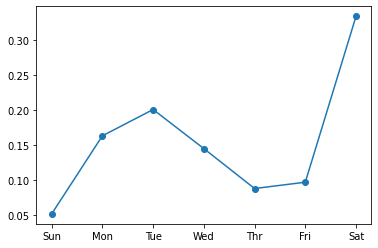

In [34]:
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('Con2D-LSTM', score, scores)
# plot scores
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

A plot of the daily RMSE is created and shown as above.

The plot shows that perhaps Thursdays are easier days to forecast than the other days and that perhaps Saturday at the end of a standard week is the hardest day to forecast.